## Step 1. 크롤링: 웹 데이터 가져오기

### BeautifulSoup을 이용해 웹 크롤링하기

모든 URL의 데이터를 가져오기

나무위키에서 최근 변경이 일어난 페이지들의 URL을 page_urls라는 변수에 저장

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import requests
from bs4 import BeautifulSoup
import re

source_url = "https://namu.wiki/RecentChanges"

req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="table")
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        page_urls.append(page_url)

page_urls = list(set(page_urls))

### 나무위키의 최근 변경 데이터 크롤링하기

문서의 본문, 제목, 카테고리에 등장하는 텍스트 데이터 가져오기

In [2]:
# 크롤링한 데이터를 데이터 프레임으로 만들기 위해 준비
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)

# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만들기
for page_url in page_urls:

    # 사이트의 html 구조에 기반하여 크롤링 수행
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name="article")
    title = contents_table.find_all('h1')[0]
    
    # 카테고리 정보가 없는 경우 확인
    if len(contents_table.find_all('ul')) > 0:
        category = contents_table.find_all('ul')[0]
    else:
        category = None
        
    content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출 
    # 만약 없는 경우, 빈 문자열로 대체
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""
    
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출
    # 만약 없는 경우, 빈 문자열로 대체
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace("\n", " "))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
        
    # 페이지 내 카테고리정보에서“분류”라는 단어와 개행 문자를 제거한 뒤 추출
    # 만약 없는 경우, 빈 문자열로 대체
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""
    
    # 모든 정보를 하나의 데이터 프레임에 저장
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)
    
# 데이터 프레임 출력
df.head(5)

,title,category,content_text
0,폴라 베어,보드카 베이스 칵테일나무위키 주류 프로젝트,은(는) 여기로 연결됩니다. 이 문서가 설명하는 칵테일의 모티브가 된 동물에 ...
1,국군기무사령부,국군기무사령부,가입 후 15일이 지나야 편집 가능한 문서입니다. 은(는) 여기로 연결됩니...
2,윌(소맥거핀),소맥거핀/영상 등장인물메이플스토리/밈짤방/애니메이션서브 주인공/애니메이션주연이 된 ...,상위 문서: 소맥거핀/영상 등장인물 소맥거핀 유니버스 윌의 모든 것을 표현하는...
3,요코하마 디엔에이 베이스타즈,일본의 야구야구단일본프로야구1949년 창단,NPB セリーグ / NPB 센트럴리그 NPB Central League ...
4,나하은,2009년 출생대구광역시 출신 인물유튜버/ㄴ대한민국의 여성 인터넷 방송인/ㄴDIA ...,어썸하은 Awesome Haeun닉네임어썸하은 (Awesome Haeun)이름나하...


모든 URL의 텍스트 데이터를 가져온 뒤, 이를 데이터 프레임의 형태로 변환한 것

데이터에 등장하는 불필요한 문자인 "\n", "분류" -> 크롤링 과정에서 replace() 함수로 제거

## Step 2. 추출: 키워드 정보 추출하기

### 텍스트 데이터 전처리하기

re.compile('[^ ㄱ-ㅣ가-힣]+') -> 한글에 대한 정규표현식 정의: 대상이 되는 텍스트 데이터에서 한글만 추출

In [3]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식
    result = hangul.sub('', text)
    return result

print(text_cleaning(df['content_text'][0]))

  은는 여기로 연결됩니다 이 문서가 설명하는 칵테일의 모티브가 된 동물에 대한 내용은 북극곰 문서를의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  부분을 에 대한 내용은  문서를의  문단을의  부분을 참조하십시오  개요 레시피 변형 레시피들 변형 변형 변형 슈터 변형 변형칵테일의 한 종류 북극곰 이라는 이름에 걸맞게 칵테일 색깔도 하얀색이다 다만 보드카가 나 들어가는 만큼 도수가 낮은 편은 아니니 주의 마셨을 때 첫 맛은 달콤하지만 보드카의 짜릿함이 끝맛으로 따라붙는다 사실 이 칵테일은 마티니의 경우처럼 변형 칵테일 레시피가 무지 많은 칵테일이다 아래 소개된 레시피만 해도 무려 개로 실제로는 아래의 레시피 외에도 무수히 많은 변형 칵테일이 존재한다폴라 배어 칵테일에 필요한 재료는 다음과 같다보드카  크렘 드 카카오 화이트  크림  위의 재료들을 모두 쉐이킹한 다음 구프 글라스에 따라주면 완성 가니쉬는 따로 존재하지 않는다보드카  온스블루 큐라소  온스 세븐업 또는 스프라이트로 탑업색  투명한 푸른빛을 띈다맛  보드카의 맛이 느껴지면서도 블루큐라소세븐업의 달달한 조화로 인해 단맛이 나면서 보드카의 독한 느낌이 나지 않는다 알코올맛과 음료수맛의 조화가 인상적인 맛 비주얼과 밸런스를 중시한다면 이 버전을 강력 추천  보드카  온스라임주스  온스 세븐업 또는 스프라이트로 탑업색  라임주스로 인해 게토레이드 레몬맛 색깔을 띈다맛  라임주스를 온스 탔을 뿐인데 상당히 신 맛이 난다 보드카의 독한 맛이 전혀 느껴지지 않을 정도 신맛을 좋아한다면 이쪽이 좋다 맛은 흡사 진 피즈와도 매우 흡사하다크렘 드 카카오   온스크렘 드 멘

### 모든 데이터에 전처리 적용하기

apply() 함수 -> 모든 데이터에 전처리를 적용하기 위해서 사용

head() 함수 -> 출력(한글을 제외한 문자들은 제거됨)

In [4]:
# 각 피처마다 데이터 전처리 적용
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))
df.head(5)

,title,category,content_text
0,폴라 베어,보드카 베이스 칵테일나무위키 주류 프로젝트,은는 여기로 연결됩니다 이 문서가 설명하는 칵테일의 모티브가 된 동물에 대한 내...
1,국군기무사령부,국군기무사령부,가입 후 일이 지나야 편집 가능한 문서입니다 은는 여기로 연결됩니다 국군기무사...
2,윌소맥거핀,소맥거핀영상 등장인물메이플스토리밈짤방애니메이션서브 주인공애니메이션주연이 된 조연거미...,상위 문서 소맥거핀영상 등장인물 소맥거핀 유니버스 윌의 모든 것을 표현하는 ...
3,요코하마 디엔에이 베이스타즈,일본의 야구야구단일본프로야구년 창단,센트럴리그 센트럴리그 요미우...
4,나하은,년 출생대구광역시 출신 인물유튜버ㄴ대한민국의 여성 인터넷 방송인ㄴ 소속 크리에이터키...,어썸하은 닉네임어썸하은 이름나하은 출생년 월 일 세대구광역시국적 대한민국...


### 말뭉치 만들기(제목, 카테고리, 본문 말뭉치)

텍스트 피처를 tolist()로 추출, join() 함수로 말뭉치 생성

In [5]:
# 각 피처마다 말뭉치 생성
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

폴라 베어 국군기무사령부 윌소맥거핀 요코하마 디엔에이 베이스타즈 나하은 일함 알리예프   임성진 네이버 웹소설 소총사격술 타나카 치에미 년대 한국의 성비 불균형 현상 파일  기무라 타쿠야 트리엔트 미사  혐잉 협회장  타이틀 및 그래픽 일일외출록 반장 롭 홀딩 프린세스 메이커 엔딩 어몽어 파일  미미미누 기에드레 두카우스카이테  버그해결 위르겐 클롭리버풀  구로다 기요타카 아잉 협회    파일   파이널     파이널 데이비 가르시아 저글링스타크래프트 시리즈 설양 사카키 신라 재건축 오컬트 내기니 아라이 사토미 토트넘 홋스퍼  진복기 하얀고양이 프로젝트 김사현 아랑 파나요티스 레초스 오페라웹 브라우저 재범오빠 찌찌파티 급식왕  급식걸즈등장인물급식왕 학교 악우 우주선 단자비디오    아뚜임렛 미국 너구리 라스칼 브리트니 스피어스 퀴즈 마법사와 검은 고양이 위즈  파일   임가륜 동백동 이동근프로게이머 년 미국 대통령 선거선거 과정 심으뜸 김현진뮤지컬 배우 부끄럼쟁이 서큐버스의 의기양양한 얼굴이 귀엽다 처인구 리그 오브 레전드  월드 챔피언십그룹 스테이지조 정일훈 스펙크 천식영원한 일의 도시 동국통감 년 아르메니아아제르바이잔 전쟁 모바일 스트라이크 왕의 딸로 태어났다고 합니다등장인물 하인샤 대사원  몬스터 마키노원피스 


### konlpy를 이용해 키워드 추출하기
#### 키워드 추출 = 명사, 혹은 형태소 단위의 문자열 추출

konlpy의 Okt tagger를 이용하여 형태소 추출

In [6]:
from konlpy.tag import Okt
from collections import Counter

# konlpy의 형태소 분석기로 명사 단위의 키워드 추출
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)
count

Counter({'은': 101,
         '여기': 173,
         '연결': 49,
         '이': 1637,
         '문서': 1145,
         '설명': 81,
         '칵테일': 8,
         '모티브': 55,
         '동물': 39,
         '대한': 326,
         '내용': 344,
         '북극곰': 2,
         '를': 394,
         '문단': 1028,
         '의': 554,
         '부분': 263,
         '참조': 68,
         '개요': 64,
         '레시피': 8,
         '변형': 25,
         '슈터': 3,
         '종류': 52,
         '이름': 329,
         '걸': 230,
         '색깔': 19,
         '하얀색': 1,
         '다만': 301,
         '보드카': 10,
         '나': 240,
         '만큼': 74,
         '도수': 1,
         '편': 286,
         '주의': 153,
         '때': 1476,
         '첫': 233,
         '맛': 27,
         '끝맛': 1,
         '사실': 335,
         '마티니': 1,
         '경우': 1081,
         '무지': 12,
         '아래': 120,
         '소개': 72,
         '해도': 168,
         '무려': 65,
         '개': 694,
         '실제': 147,
         '외': 145,
         '무수': 5,
         '존재': 256,
         '폴라': 1,
         '재료': 

### 키워드 가다듬기: 한 글자 키워드 제거하기

In [7]:
# 한글자 키워드 제거
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'공격': 1290, '문서': 1145, '경우': 1081, '이전': 1068, '문단': 1028, '때문': 1019, '역사': 999, '엔딩': 832, '자신': 788, '상태': 735, '이후': 713, '경기': 619, '사람': 583, '이상': 565, '카드': 547, '정도': 545, '저글링': 529, '시즌': 521, '다른': 514, '사용': 507, '속도': 505, '모습': 449, '체력': 443, '사항': 442, '시작': 437, '뉴스': 436, '토론': 432, '합의': 417, '게임': 412, '리그': 393, '왕자': 393, '문제': 392, '아버지': 385, '다시': 379, '생각': 370, '하나': 366, '또한': 355, '캐릭터': 355, '내용': 344, '상황': 341, '사실': 335, '기록': 334, '이름': 329, '대한': 326, '브리트니': 325, '다음': 315, '가장': 303, '등장': 303, '다만': 301, '플레이어': 297, '우즈': 295, '요정': 292, '모든': 289, '해당': 289, '현재': 287, '시간': 286, '선수': 284, '기본': 283, '스킬': 280, '매우': 274, '모두': 271, '이벤트': 269, '상대': 268, '부분': 263, '가지': 262, '추가': 259, '영상': 257, '존재': 256, '매력': 251, '감독': 249, '프린세스': 245, '유닛': 244, '자막': 241, '역시': 238, '지금': 233, '한국': 231, '다년': 231, '위해': 228, '승리': 218, '수도': 217, '사격': 217, '자세': 213, '미사': 213, '관련': 212, '네이버': 212, '정신': 211, '여왕': 211, '자체': 210, '머리': 

### 키워드 가다듬기: 불용어 사전 (실질적인 의미가 없는 키워드 제거)

#### 불용어 = (관사나 접속사 등) 실질적인 의미가 없는 키워드이면서 동시에 의미적인 독립을 할 수 없는 품사

In [8]:
# 한국어 약식 불용어사전 예시 파일
# 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "../data/korean_stopwords.txt"

# 텍스트 파일 오픈
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


새로운 불용어를 추가한 뒤, Counter 객체에서 불용어 리스트에 포함된 형태소를 제거

In [9]:
# 나무위키 페이지에 맞는 불용어 추가
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)
    
# 키워드 데이터에서 불용어 제거
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'공격': 1290, '이전': 1068, '문단': 1028, '역사': 999, '엔딩': 832, '상태': 735, '경기': 619, '사람': 583, '카드': 547, '저글링': 529, '시즌': 521, '속도': 505, '체력': 443, '사항': 442, '시작': 437, '뉴스': 436, '토론': 432, '합의': 417, '게임': 412, '리그': 393, '왕자': 393, '문제': 392, '아버지': 385, '다시': 379, '캐릭터': 355, '기록': 334, '대한': 326, '브리트니': 325, '등장': 303, '플레이어': 297, '우즈': 295, '요정': 292, '현재': 287, '선수': 284, '기본': 283, '스킬': 280, '이벤트': 269, '상대': 268, '부분': 263, '가지': 262, '영상': 257, '존재': 256, '매력': 251, '감독': 249, '프린세스': 245, '유닛': 244, '자막': 241, '역시': 238, '지금': 233, '한국': 231, '다년': 231, '위해': 228, '승리': 218, '수도': 217, '사격': 217, '자세': 213, '미사': 213, '관련': 212, '네이버': 212, '정신': 211, '여왕': 211, '자체': 210, '머리': 210, '당시': 208, '인간': 207, '달리': 206, '레벨': 206, '보통': 205, '우승': 205, '이유': 204, '작품': 203, '아르메니아': 203, '보스': 202, '고기': 201, '친구': 201, '속성': 201, '그냥': 199, '지원': 198, '획득': 198, '계속': 196, '라면': 196, '아르바이트': 196, '편이': 195, '시리즈': 192, '일본': 191, '능력': 190, '버전': 188, '반응': 188, '아

## Step 3. 시각화: 워드 클라우드 시각화하기

In [10]:
import random
import pytagcloud
import webbrowser

# 가장 출현 빈도수가 높은 40개의 단어 선정
ranked_tags = remove_char_counter.most_common(40)

# pytagcloud로 출력할 40개의 단어 입력
# 단어 출력의 최대 크기는 80으로 제한
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

# pytagcloud 이미지 생성
# 폰트는 나눔 고딕 사용
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


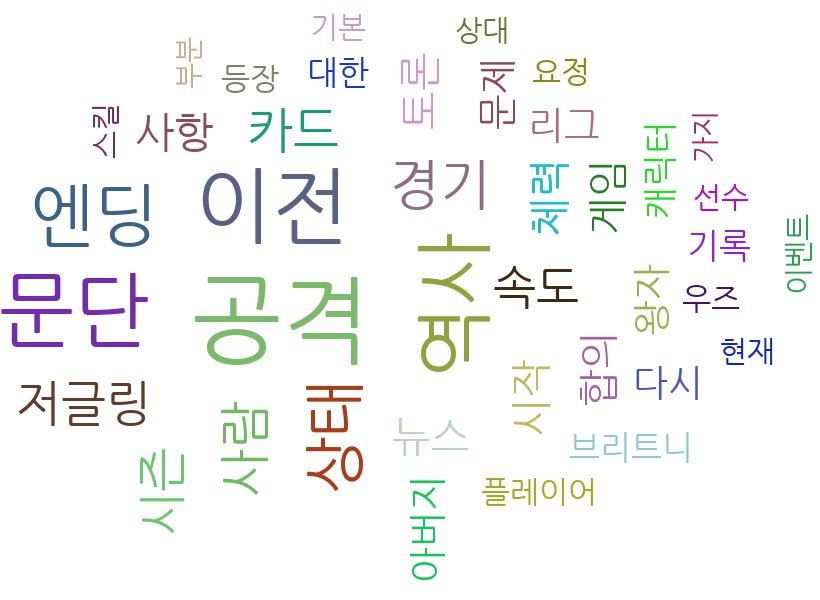

In [11]:
# 생성한 이미지를 주피터 노트북상에서 출력
from IPython.display import Image
Image(filename='wordcloud.jpg')